In [75]:
import os
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
import styling
from matplotlib.ticker import MultipleLocator

In [76]:
main_path = Path.cwd().parent

In [81]:
from styling import color_palette

model_styles = {
    "DPNets": {
        "color": color_palette[0],
        "linestyle": "solid",
    },
    "DPNets-relaxed": {
        "color": color_palette[1],
        "linestyle": "solid",
    },
    "VAMPNets": {
        "color": color_palette[2],
        "linestyle": "solid",
    },
    "DynamicalAE": {
        "color": color_palette[3],
        "linestyle": "solid",
    },
    "ConsistentAE": {
        "color": color_palette[4],
        "linestyle": "solid",
    },
    "DMD": {
        "color": "gray",
        "linestyle": "solid",
    },
    "KernelDMD": {
        "color": "gray",
        "linestyle": "dotted",
    },
    "Oracle-Features": {
        "color": color_palette[5],
        "linestyle": "solid",
    },
    "PINNs": {
        "color": color_palette[6],
        "linestyle": "solid",
    }
}

##### Left Panel

In [82]:
# Logistic map data
results_path = main_path / 'logistic_map/results_training_loop_inspection/'
os.listdir(results_path)
_tmp = {}
for filename in os.listdir(results_path):
    model_name = filename.split('_')[0]
    if model_name not in _tmp:
        _tmp[model_name] = []
    with open(results_path / filename, 'rb') as f:
        restored = pickle.load(f)
    _tmp[model_name].append(restored)

LOGISTIC = {}
for model_name, model_data in _tmp.items():
    LOGISTIC[model_name] = {
        'x': np.arange(len(model_data)),
        'data': np.array(model_data).mean(axis=1)
    }

# Continuous dynamics data
with open(main_path / 'langevin.pkl', 'rb') as f:
    restored_obj = pickle.load(f)
LANGEVIN = {
    'x': restored_obj['step'],
    'data': restored_obj['eigenvalues'],
    'hlines': np.squeeze(restored_obj['reference'])
}

#### Middle Panel

In [83]:
# Ordered MNIST data
reports = {}
exp_path = main_path / "ordered_MNIST/results/"
for file in os.listdir(exp_path):
    if file.endswith(".pkl"):
        with open(exp_path / file, "rb") as f:
            restored_report = pickle.load(f)
            model_name = restored_report.pop("name")
            reports[model_name] = restored_report

ORDERED_MNIST = {}
for model_name, report in reports.items():
    if model_name == "KernelDMD-RBF":
        model_name = "KernelDMD"
    ORDERED_MNIST[model_name] = {
        "data": np.asanyarray(report["accuracy"]),
    }
ORDERED_MNIST["hlines"] = 0.2

# Fluid Flow data DUMMY DATA
results_path = main_path / 'fluid/results/'
os.listdir(results_path)
_tmp = {}
for filename in os.listdir(results_path):
    model_name = filename.split('_')[0]
    if model_name not in _tmp:
        _tmp[model_name] = []
    with open(results_path / filename, 'rb') as f:
        restored = pickle.load(f)
    if restored is not None:
        _tmp[model_name].append(restored)

FLUID_FLOW = {}
for model_name, model_data in _tmp.items():
    if len(model_data) > 0:
        FLUID_FLOW[model_name] = {
            'x': np.arange(len(model_data)),
            'data': np.array(model_data).mean(axis=1)
        }
#Add old data:
import pandas as pd
df = pd.read_csv(main_path / 'fluid/fluid_flow_results.csv', sep='\t')
for model_name in model_styles.keys():
    if model_name in df.columns:
        FLUID_FLOW[model_name] = {
            'x': np.arange(len(df)),
            'data': df[model_name].values
        }

#### Right Panel

In [84]:
FES = {}
for model_name in ["DPNets", "Nystrom-PCR",]:
    _tmp = np.load(main_path / f"chignolin/FES_{model_name}.npz")        
    FES[model_name] = {
        "data": _tmp["data"],
        "x": _tmp["x"],
    }

## The UBER figure

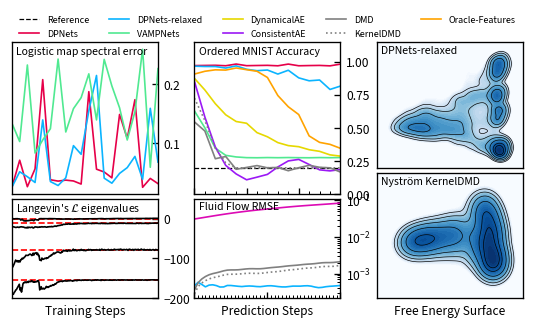

In [87]:
pad = 0.03
caption_size = 7

fig = plt.figure(figsize=styling.figsize(1, 1.8))
gs = fig.add_gridspec(11, 3, wspace=0.25)

# Logistic Map
ax_logistic = fig.add_subplot(gs[1:7, 0])
for model_name in model_styles.keys():
    if model_name in LOGISTIC:
        model_data = LOGISTIC[model_name]
        ax_logistic.plot(model_data['x'], model_data['data'], label=model_name, **model_styles[model_name])
ax_logistic.set(**{
    'xticks': [],
    'xmargin': 0
})
ax_logistic.text(pad, 1 - pad, r"Logistic map spectral error", transform=ax_logistic.transAxes, fontsize=caption_size, verticalalignment='top')
ax_logistic.tick_params(direction='in', labelbottom=False)
ax_logistic.yaxis.tick_right()

# Langevin
ax_langevin = fig.add_subplot(gs[7:, 0])
for v in LANGEVIN['hlines']:
    ax_langevin.axhline(v, color='red', linestyle='dashed', label='Reference')
ax_langevin.plot(LANGEVIN['x'], LANGEVIN['data'], color='black', label='Eigenvalues')

ax_langevin.set(**{
    'xlabel': 'Training Steps',
    'ylim': (-200, 50),
    'xticks': [],
    'xmargin': 0
})
ax_langevin.text(pad, 1 - pad, r"Langevin's $\mathcal{L}$ eigenvalues", transform=ax_langevin.transAxes, fontsize=caption_size, verticalalignment='top')
ax_langevin.tick_params(direction='in', labelbottom=False)
ax_langevin.yaxis.tick_right()

# Ordered MNIST
ax_ordered_mnist = fig.add_subplot(gs[1:7, 1])
ax_ordered_mnist.axhline(0.2, color = 'k', ls = 'dashed', lw=0.75, label = 'Reference')

for model_name in model_styles.keys():
    if model_name in ORDERED_MNIST:
        model_data = ORDERED_MNIST[model_name]
        ax_ordered_mnist.plot(model_data['data'], label=model_name, **model_styles[model_name])

ax_ordered_mnist.set(**{
    'ylim': (0,  1.15),
    'xmargin': 0
})
ax_ordered_mnist.xaxis.set_minor_locator(MultipleLocator(1))
ax_ordered_mnist.text(pad, 1 - pad, 'Ordered MNIST Accuracy', transform=ax_ordered_mnist.transAxes, fontsize=caption_size, verticalalignment='top')
ax_ordered_mnist.tick_params(which='both', direction='in', labelbottom=False)
ax_ordered_mnist.yaxis.tick_right()

# Fluid Flow
ax_fluid_flow = fig.add_subplot(gs[7:, 1])
for model_name in model_styles.keys():
    if model_name in FLUID_FLOW:
        model_data = FLUID_FLOW[model_name]
        ax_fluid_flow.plot(model_data['data'], label=model_name, **model_styles[model_name])

ax_fluid_flow.set(**{
    'xlabel': 'Prediction Steps',
    'xmargin': 0,
    'yscale': 'log',
})

ax_fluid_flow.xaxis.set_minor_locator(MultipleLocator(1))
ax_fluid_flow.tick_params(which='both', direction='in', labelbottom=False)
ax_fluid_flow.text(pad, 1 - pad, 'Fluid Flow RMSE', transform=ax_fluid_flow.transAxes, fontsize=caption_size, verticalalignment='top')
ax_fluid_flow.yaxis.tick_right()

# Chignolin - DPNets
ax_chignolin_dp = fig.add_subplot(gs[1:6, 2])
x, fes = FES['DPNets']['x'], FES['DPNets']['data']
ax_chignolin_dp.tricontourf(x[:, 0], x[:, 1], fes, levels = np.linspace(0, 20, 100), cmap='Blues_r', vmax=6.5);
ax_chignolin_dp.tricontour(x[:, 0], x[:, 1], fes, levels = [0.5, 1, 2, 3, 4, 5], linewidths=0.4, colors='k');
ax_chignolin_dp.set(**{
    'xticks': [],
    'yticks': [],
})
ax_chignolin_dp.text(pad, 1 - pad, 'DPNets-relaxed', transform=ax_chignolin_dp.transAxes, fontsize=caption_size, verticalalignment='top')

# Chignolin - Nystrom-PCR
ax_chignolin_nys = fig.add_subplot(gs[6:, 2])
x, fes = FES['Nystrom-PCR']['x'], FES['Nystrom-PCR']['data']
ax_chignolin_nys.tricontourf(x[:, 0], x[:, 1], fes, levels = np.linspace(0, 20, 100), cmap='Blues_r', vmax=6.5);
ax_chignolin_nys.tricontour(x[:, 0], x[:, 1], fes, levels = [0.5, 1, 2, 3, 4, 5], linewidths=0.4, colors='k');
ax_chignolin_nys.set(**{
    'xticks': [],
    'yticks': [],
    'xlabel': 'Free Energy Surface',
})
ax_chignolin_nys.text(pad, 1 - pad, 'Nyström KernelDMD', transform=ax_chignolin_nys.transAxes, fontsize=caption_size, verticalalignment='top')

# Legend
ax_legend = fig.add_subplot(gs[0, :])
ax_legend.axis('off')
ax_legend.legend(*ax_ordered_mnist.get_legend_handles_labels(), loc='center', ncol=5, frameon=False, fontsize=6)
fig.savefig('dpnets.pdf', bbox_inches='tight', dpi=300)